# Time Series Analysis: Part I

## 1. Using Basic Statistical Models

###### as a beginner -|-

In [188]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

#import statsmodels.formula.api as smf            # statistics and econometrics
#import statsmodels.tsa.api as smt
#import statsmodels.api as sm
#import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [223]:
ads = pd.read_csv('./Downloads/ads.csv',index_col=['Time'],parse_dates=['Time'])
currency = pd.read_csv('./Downloads/currency.csv',index_col=['Time'],parse_dates=['Time'])

$\verb|currency|$ represents in game currency while $\verb|ads_wt|$ represent ads watch time.

In [190]:
currency.head()

GEMS_GEMS_SPENT
Time                       
2017-05-01          1199436
2017-05-02          1045515
2017-05-03           586111
2017-05-04           856601
2017-05-05           793775

Text(0, 0.5, 'Ads Watched')

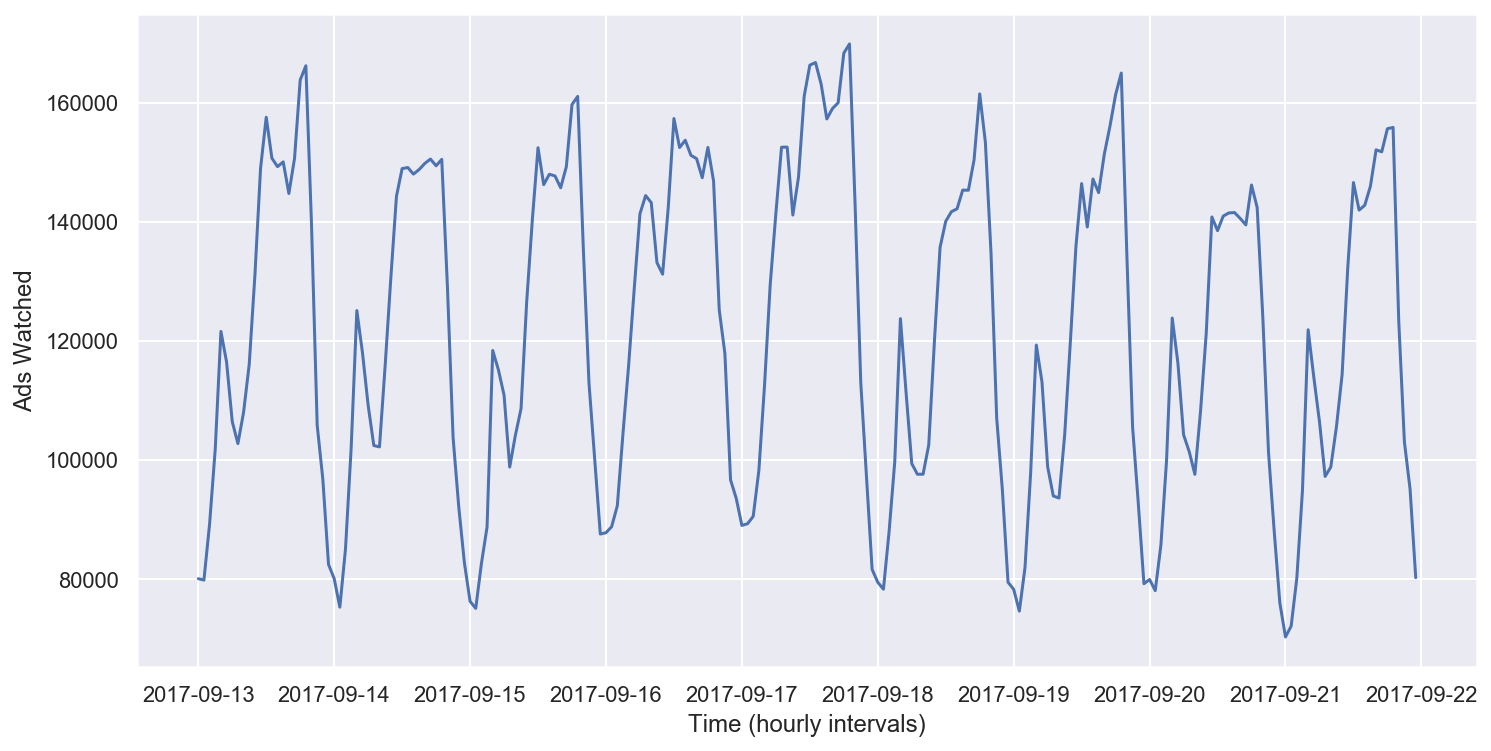

In [191]:
plt.figure(figsize = (12,6))
plt.plot(ads.Ads)
plt.xlabel('Time (hourly intervals)')
plt.ylabel('Ads Watched')

Text(0, 0.5, 'In-Game Currency Spent')

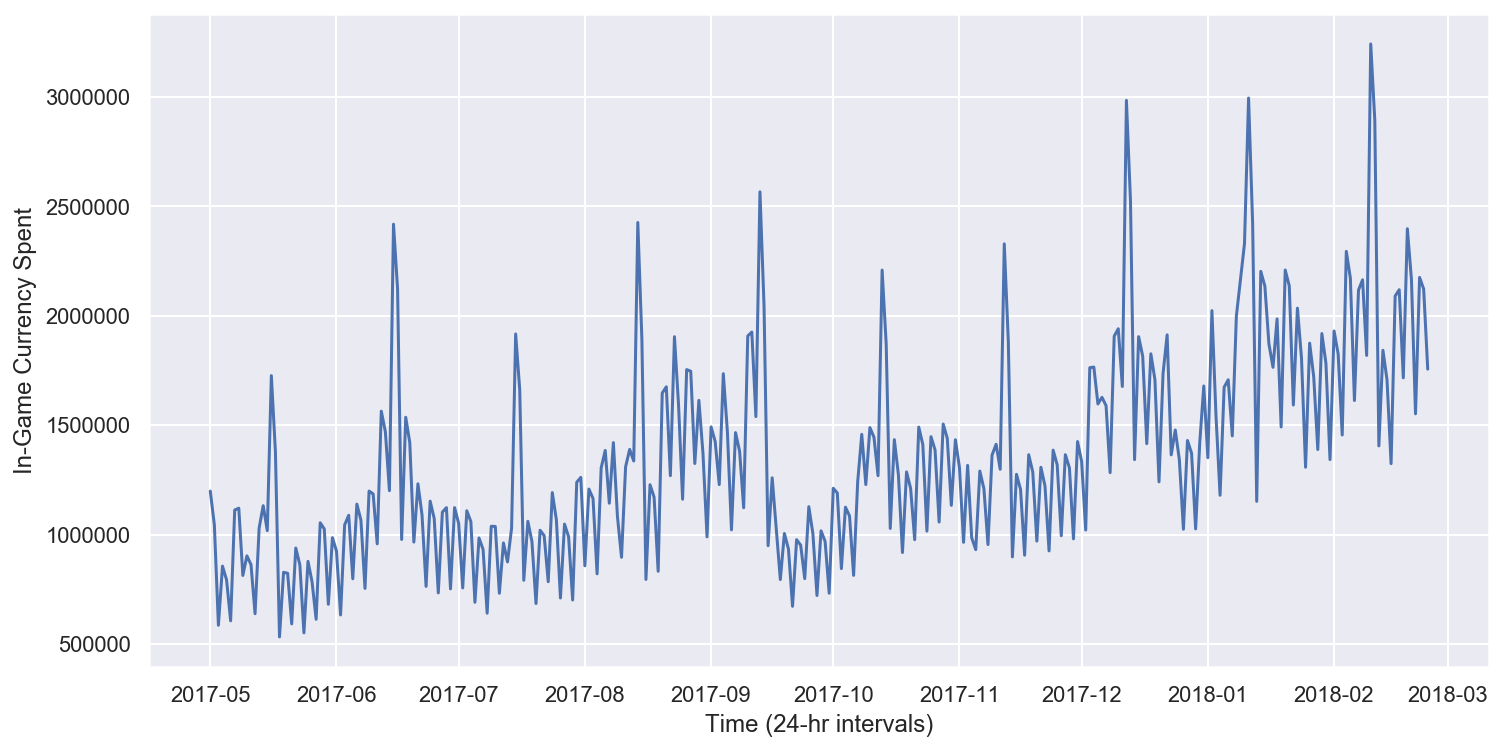

In [192]:
plt.figure(figsize = (12,6))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.xlabel('Time (24-hr intervals)')
plt.ylabel('In-Game Currency Spent')

### In order to judge predictions, we would need $\verb|Forecast Quality Metrics|$, some of which are imported Below

In [193]:
from sklearn.metrics import r2_score,median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

Since we don't have $\verb|Mean Absolute Percentage Error|$, so we make one ourselves.

In [294]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Moving Average as a Model

$\hat{y_t} = \frac{1}{k}\sum_{n=1}^{k} y_{t-n}$

In [195]:
def moving_averages(series,n):
    '''
    Returns mean of last 'n' instances.
    '''
    return np.average(series[len(series)-n:])

moving_averages(ads,24)

116805.0

### This 'Vanilla' Predictor might not be able to make predictions far into the future, but it has one special use, that is--$\textit{Smoothing the Original Time Series to Identify Trends}$.

We can use $\verb|DataFrame.rolling(window).mean()|$

In [196]:
def plotMovingAverages(series, window, scale = 1.96,plot_intervals = True, plot_anomalies = True):
    
    rolling_avg = series.rolling(window).mean()
    
    plt.figure(figsize = (16,8))
    plt.title("Moving Average \n Window size: {}".format(window))
    plt.plot(rolling_avg,'g',label = "Rolling Mean Trend")
    
    if plot_intervals:
        mae = mean_absolute_error(series[window:],rolling_avg[window:])
        deviation = np.std(series[window:] - rolling_avg[window:])
        upper_bound = rolling_avg + (mae + scale*deviation)
        lower_bound = rolling_avg - (mae + scale*deviation)
        plt.plot(upper_bound,'r--',label = "Lower & Upper Bounds")
        plt.plot(lower_bound,'r--')
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index = series.index, columns = series.columns)
            anomalies[series > upper_bound] = series[series > upper_bound]
            anomalies[series < lower_bound] = series[series < lower_bound]
            plt.plot(anomalies,'ro')
            
    plt.plot(series[window:], label = "Actual Values")
    plt.legend()
    

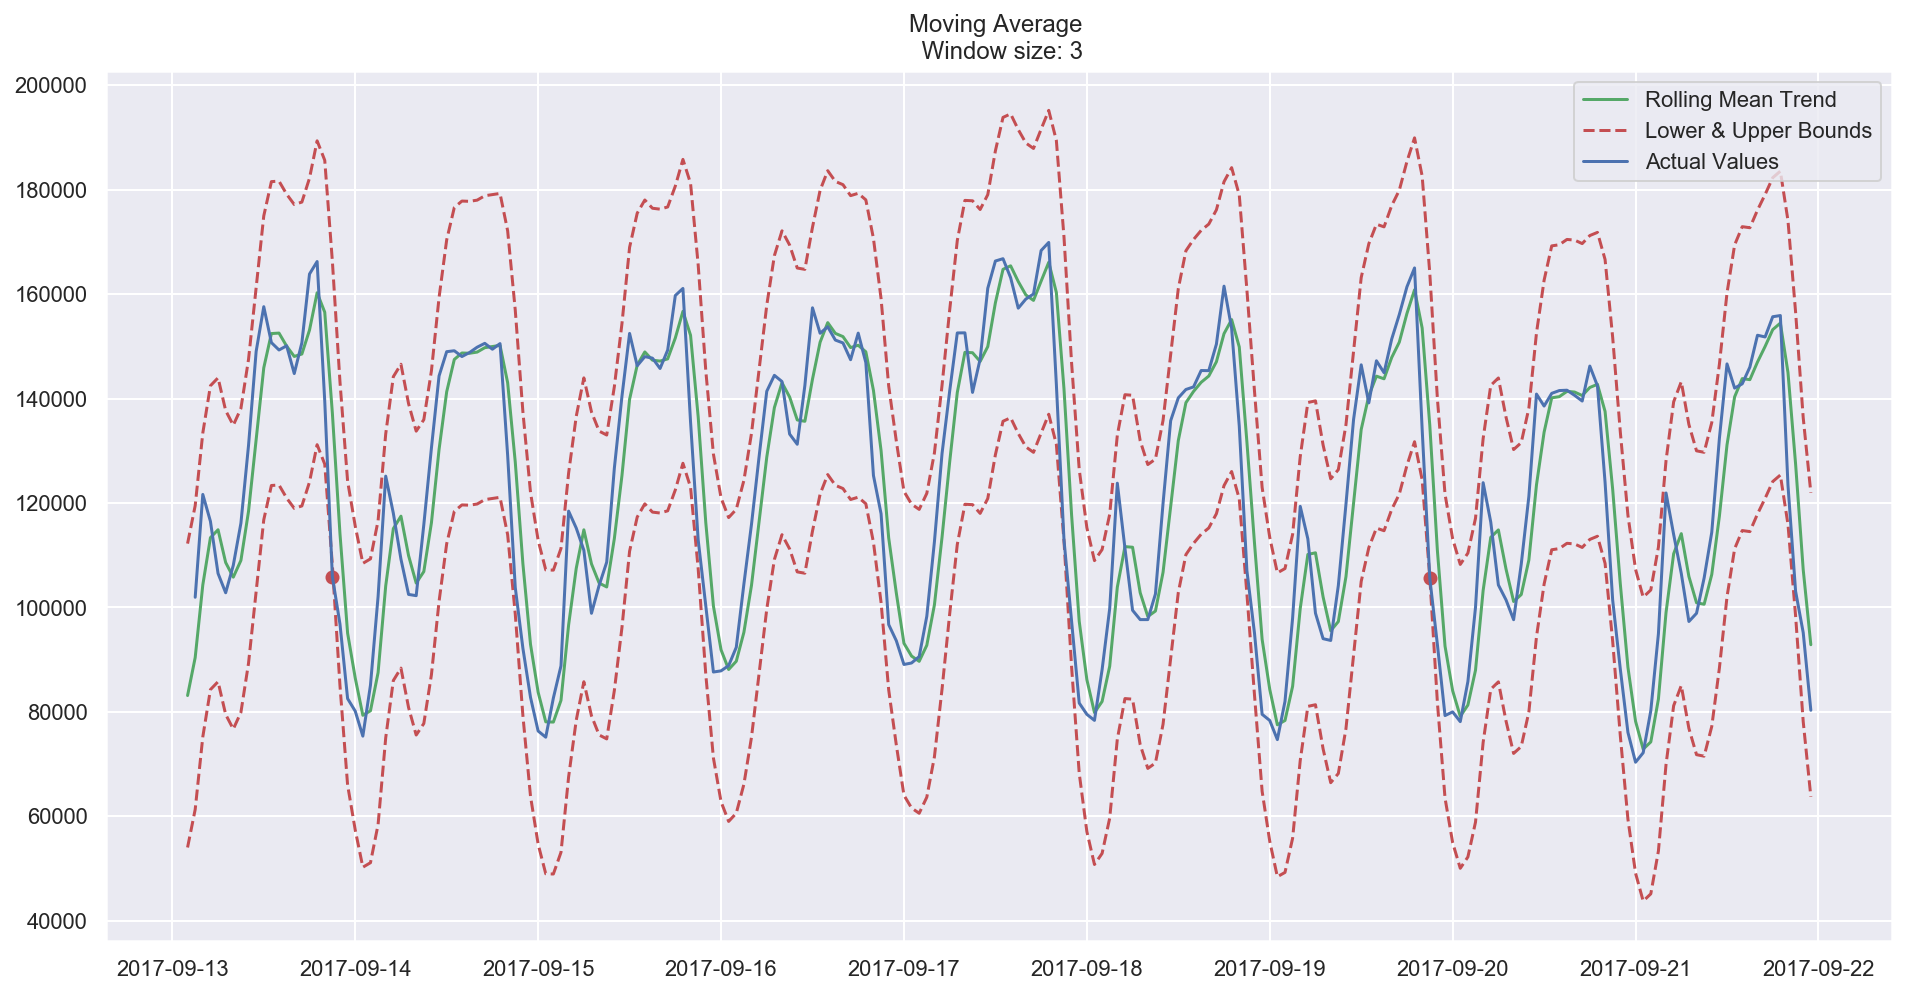

In [197]:
plotMovingAverages(ads,3)

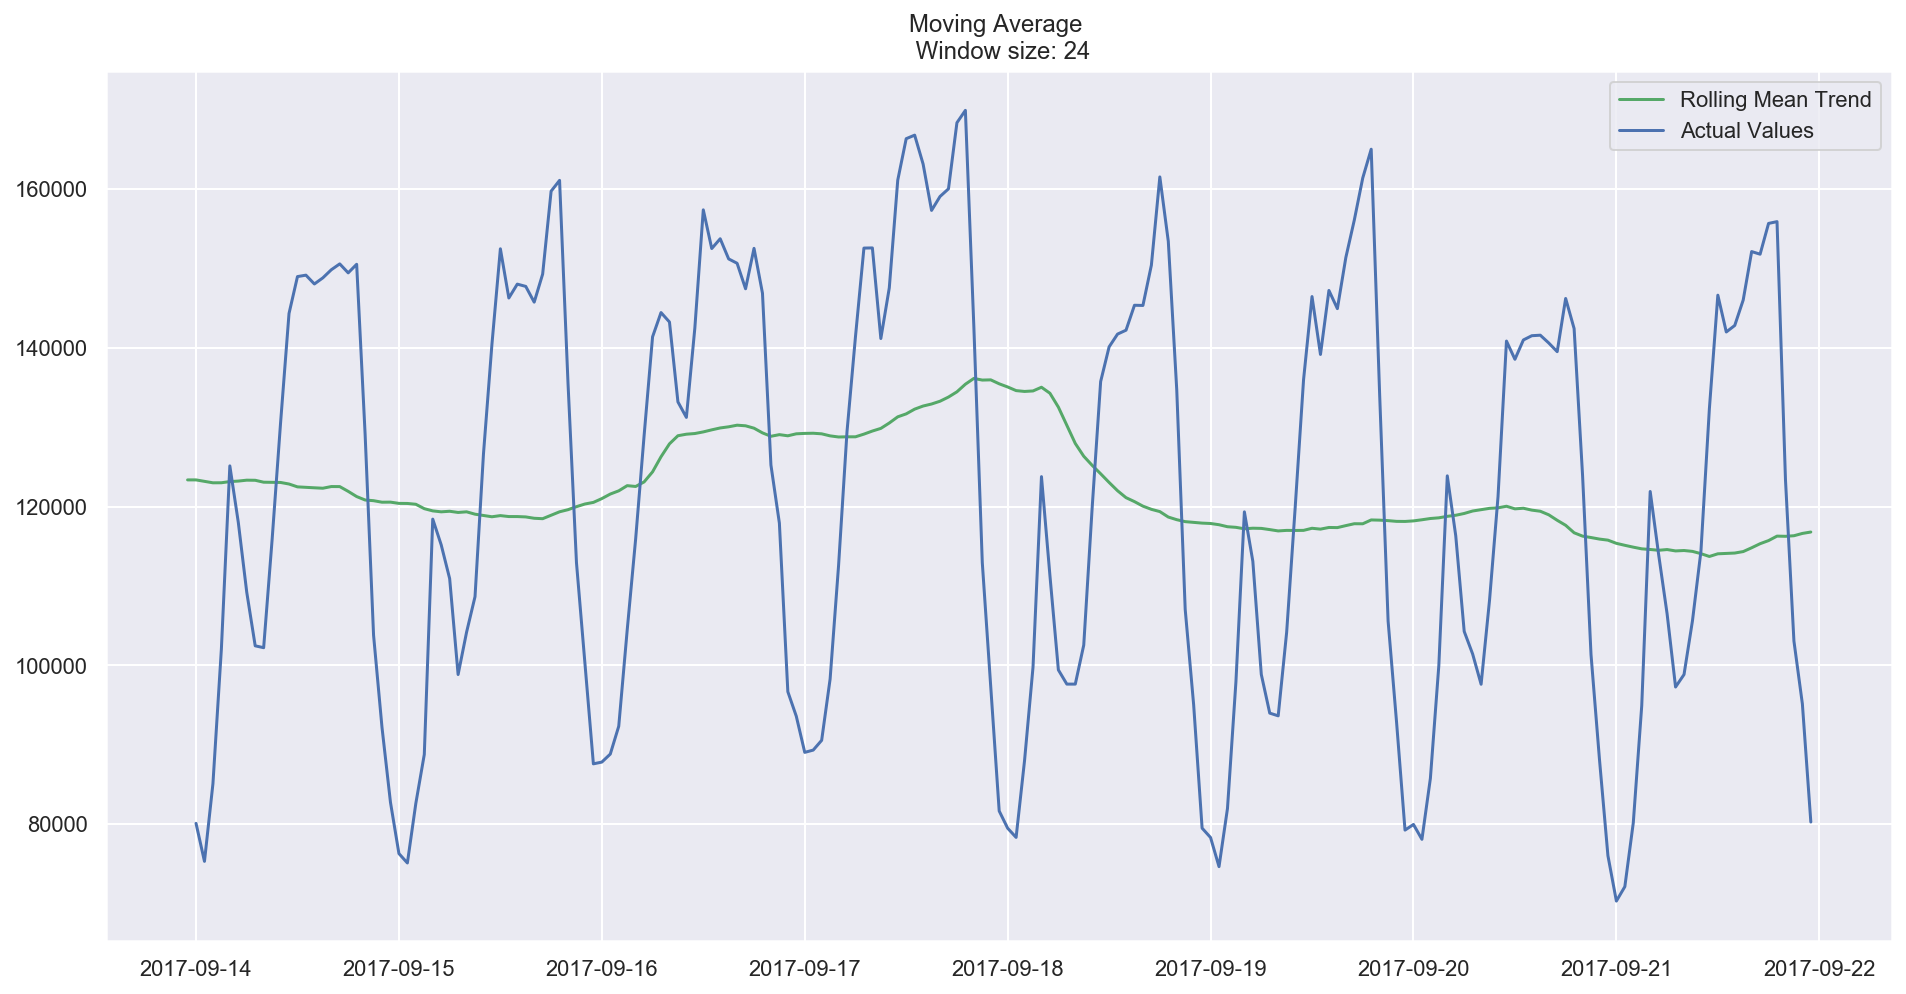

In [198]:
plotMovingAverages(ads,24,plot_intervals=False)

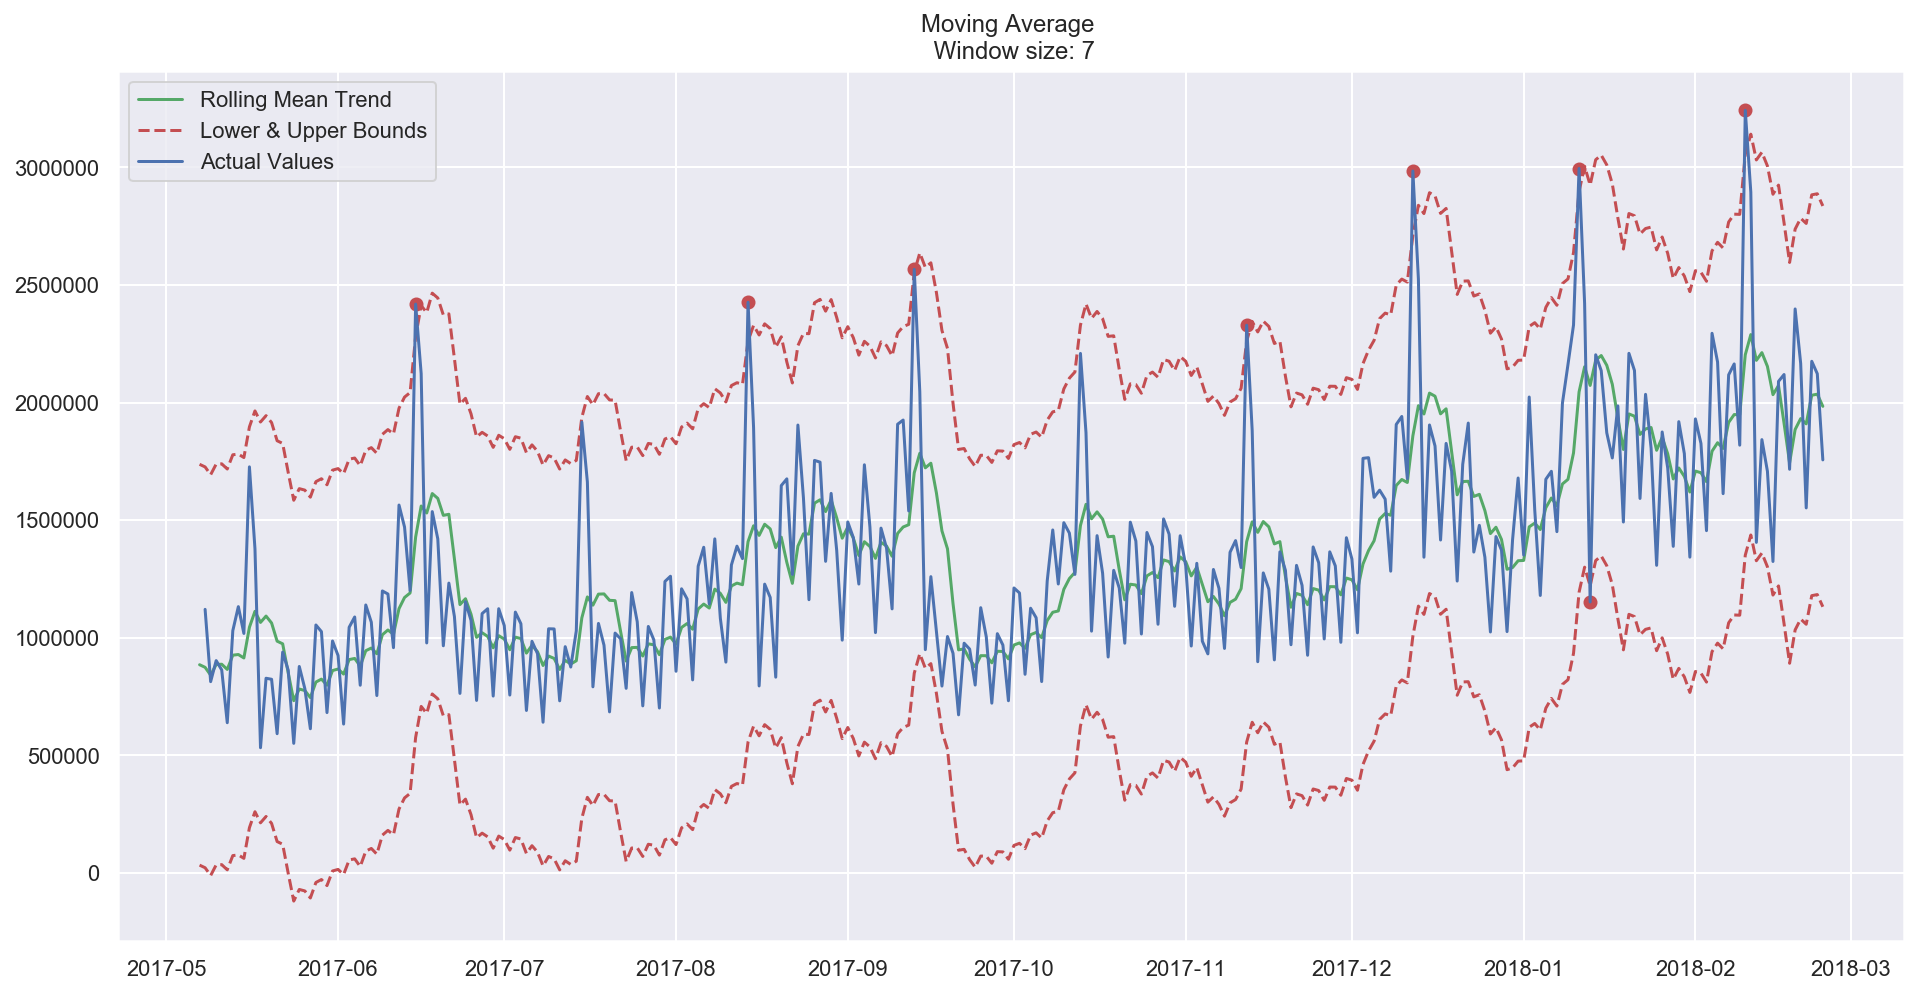

In [199]:
test = plotMovingAverages(currency,7)

##### We can clearly see the problem in our simple approach of using moving averages as it was not able to recognize the monthly trends and marked them as outliers each month.

To tackle that, we first try to modify our model by using weighted averages:

$\hat{y_t} = \frac{1}{k}\sum_{n=1}^{k} \omega_n y_{t-n}$

with $\sum_{i = 1}^{i = k} \omega_i = 1$

In [200]:
def weighted_average(series,weights):
    weights.sort(reverse= True)
    result = 0
    for i in range(len(weights)):
        result += series.iloc[-i-1]*weights[i]
    result /= len(weights)
    return float(result)

In [201]:
weighted_average(ads,[0.1,.2,.3,.4])

23404.0

## Exponential Smoothing

Now, instead of taking weighted average of last few instances, what if we take weighted average of all last instances with these averages decreasing exponentially.

Thus the following recursive formula for exponentially decreasing weighted average is followed:

$\hat{y_t} = \alpha y_t + (1-\alpha)\hat y_{t-1}$

i.e. The current model value is weighted average between current true value and the previous model value

In [202]:
def exponential_smoothing(series, alpha):
    
    result = [float(series.iloc[0])]
    for i in range(1,len(series)):
        result.append(float(series.iloc[i] * alpha + (1-alpha) * result[i-1]))
    return result

In [203]:
def plot_Exponential_Smoothing(series,alphas):
    plt.style.context('seaborn-white')
    plt.figure(figsize = (16,8))
    for alpha in alphas:
        
        plt.plot(pd.DataFrame(exponential_smoothing(series,alpha),index = series.index,columns = series.columns),label = "Alpha = {}".format(alpha))
    plt.plot(series,'g',label = "Actual Series")
    plt.legend()

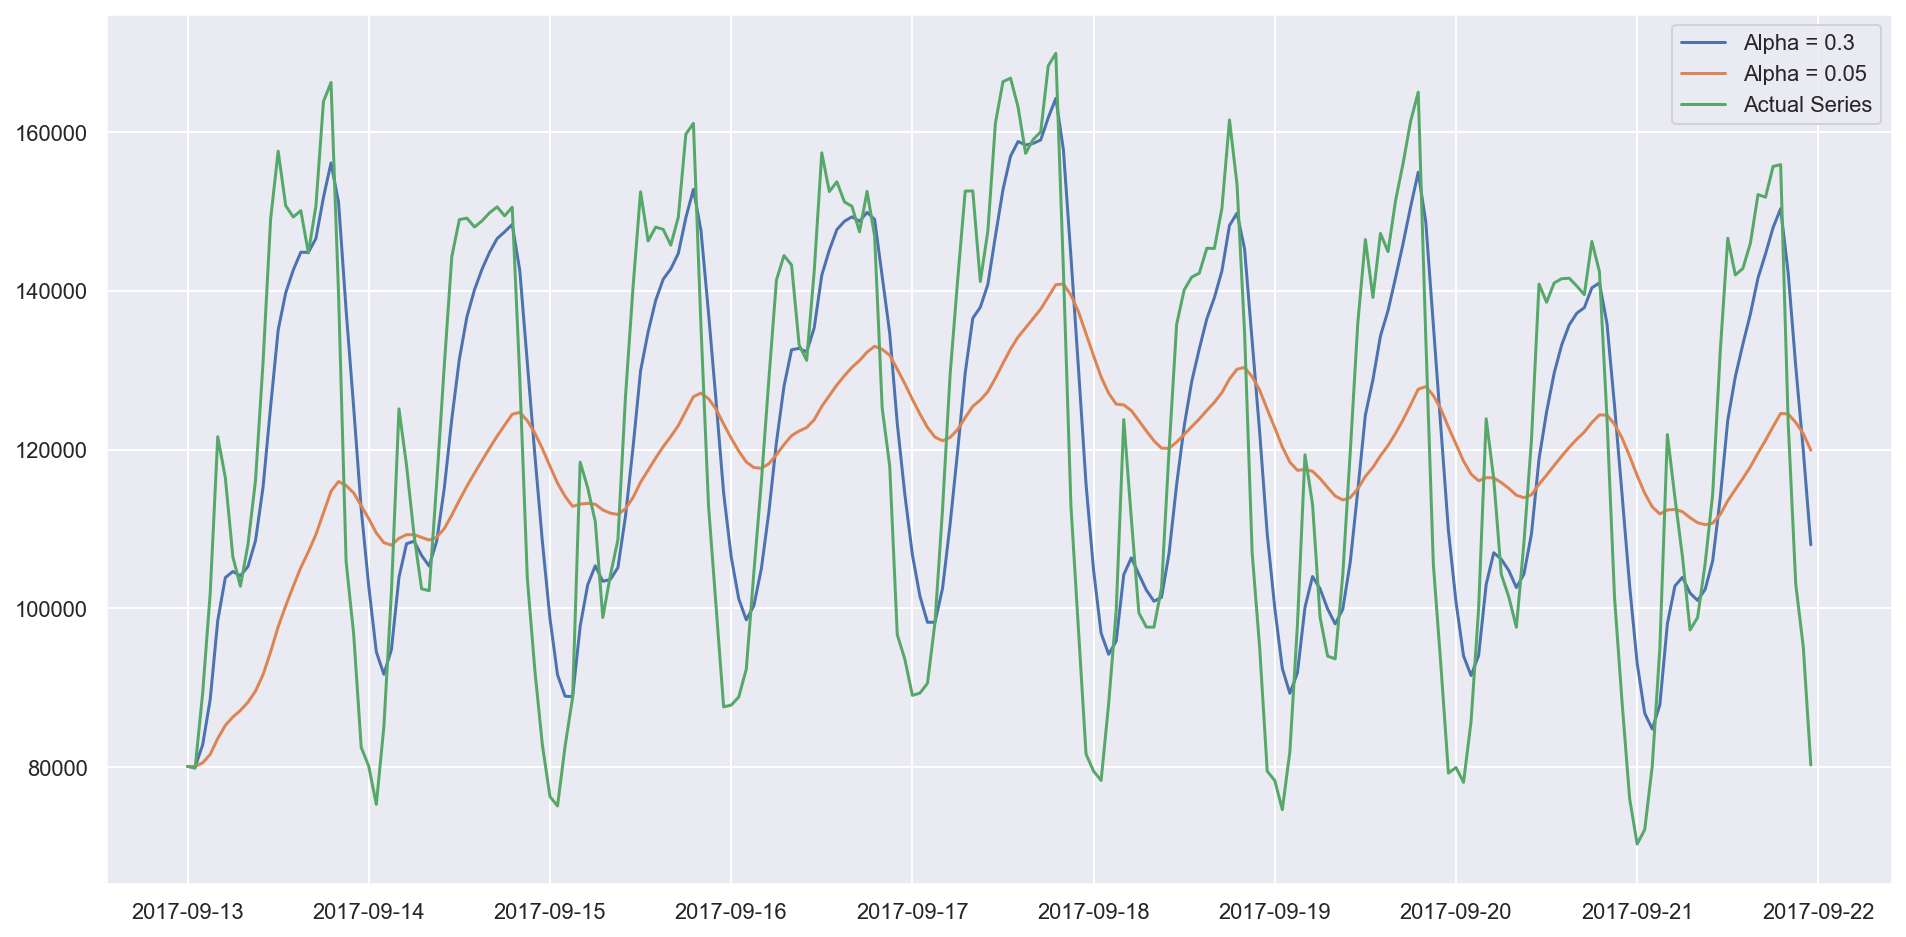

In [204]:
plot_Exponential_Smoothing(ads,[0.3,0.05])

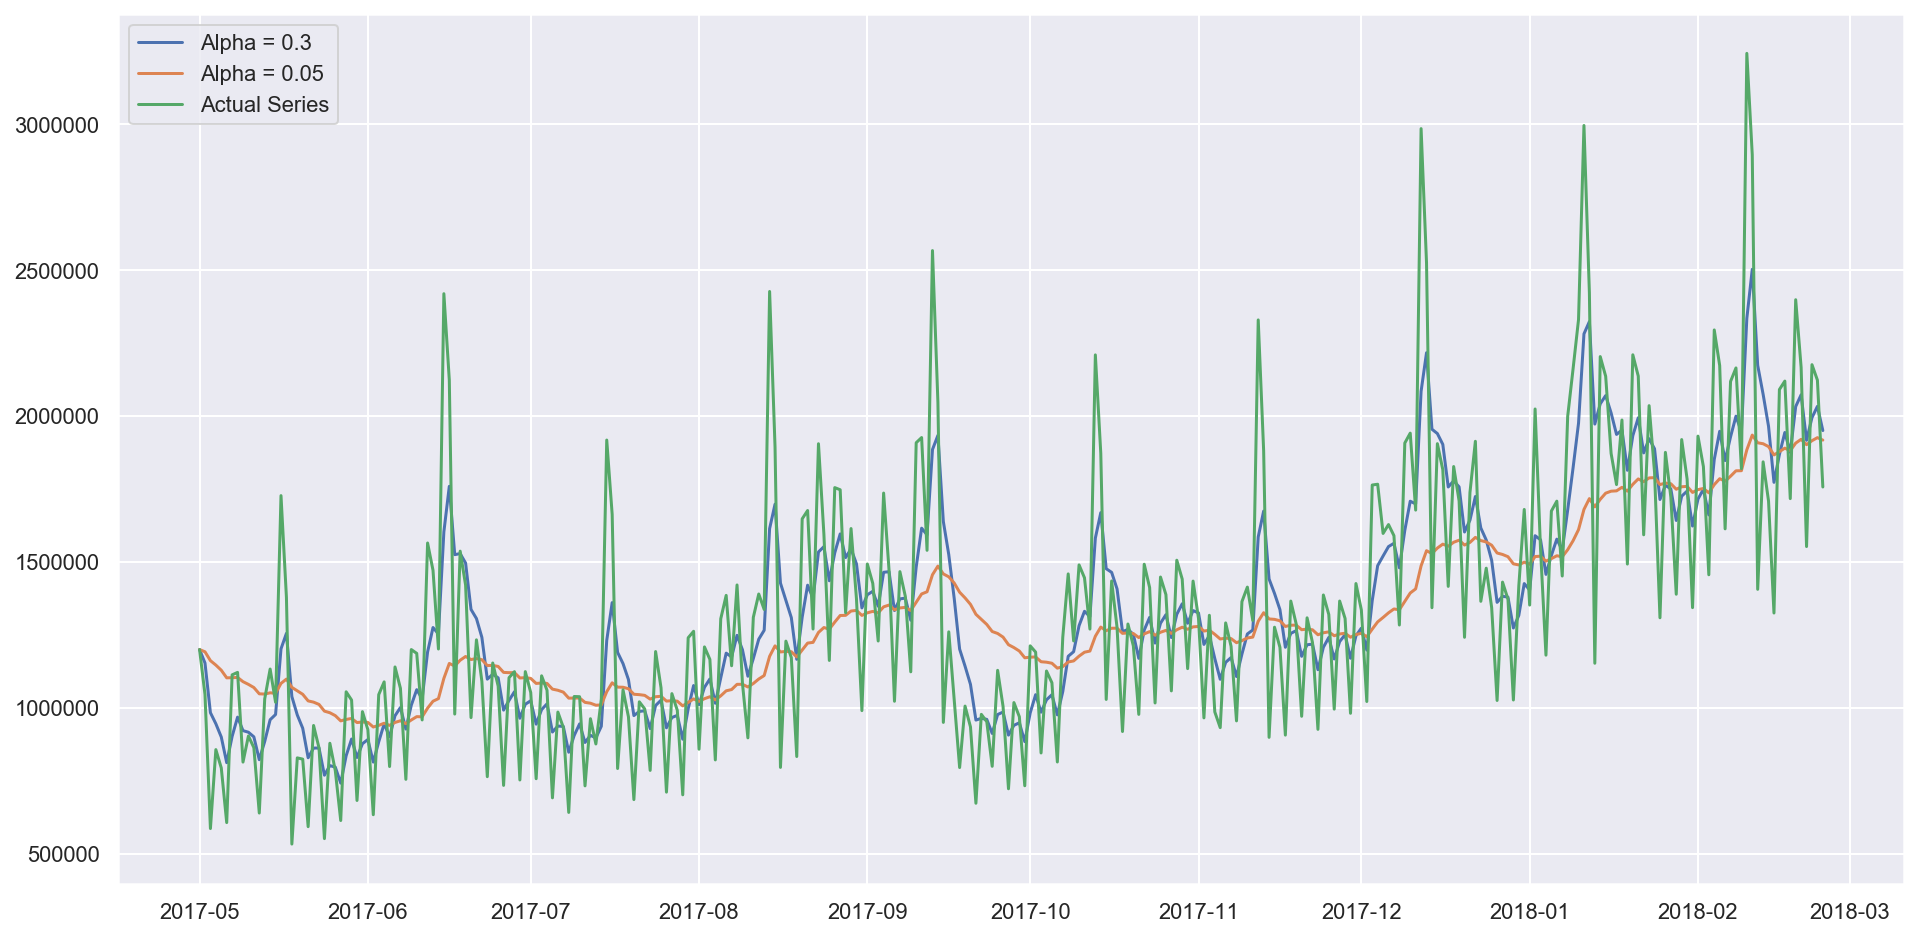

In [205]:
plot_Exponential_Smoothing(currency,[0.3,0.05])

##### We can see clearly that it doesn't shy away from recognizing monthly trends and peaks for the given series, thus this can act as a nice smoothing function without much loss in the features and trends

## Double Exponential Smoothing

#### Upto now, we were able to predict only one future point, now with help of some more advanced techniques we would extend even further and also get more smoothing in the process.

#### In this Method, we have two components, $intercept$ or $level$ ($l$) and $slope$ or $trend$ ($b$).
We will apply exponenetial Smoothing to both of them assuming that the future values of time series changes dependes on the previous weighted values. 
#### Thus we obtain the following three rules:-
$l_x = \alpha y_x + (1-\alpha)(l_{x-1} + b_{x-1})$

$b_x = \beta (l_x - l_{x-1}) + (1-\beta) b_{x-1}$

$\hat y_{x+1} = l_x + b_x$

$\alpha$ is responsible for series smoothing around the trend.

$\beta$ is responsible for the smoothing of the trend itself.

In [206]:
def double_exponential_smoothing(series, alpha, beta):
    intercept = [float(series.iloc[0])]
    slope = [series.iloc[1] - series.iloc[0]]
    result = [float(series.iloc[0])]
    for i in range(1,len(series)):
        
        intercept.append(float(alpha*series.iloc[i] + (1-alpha)*(intercept[i-1] + slope[i-1])))
        slope.append(beta*(intercept[i] - intercept[i-1]) + (1-beta)*(slope[i-1]))
        result.append(intercept[i-1] + slope[i-1])
    return result, intercept, slope

In [207]:
def plot_double_exponential_smoothing(series, alphas, betas):
    plt.style.context('seaborn-white')
    plt.figure(figsize = (16,8))
    plt.plot(series,'r',label = "Actual Series")
    for alpha in alphas:
        for beta in betas:
            res,_,_ = double_exponential_smoothing(series,alpha,beta)
            plt.plot(pd.DataFrame(res,index = series.index,columns = series.columns),label = "Alpha = {} & Beta = {}".format(alpha,beta))
    plt.legend()

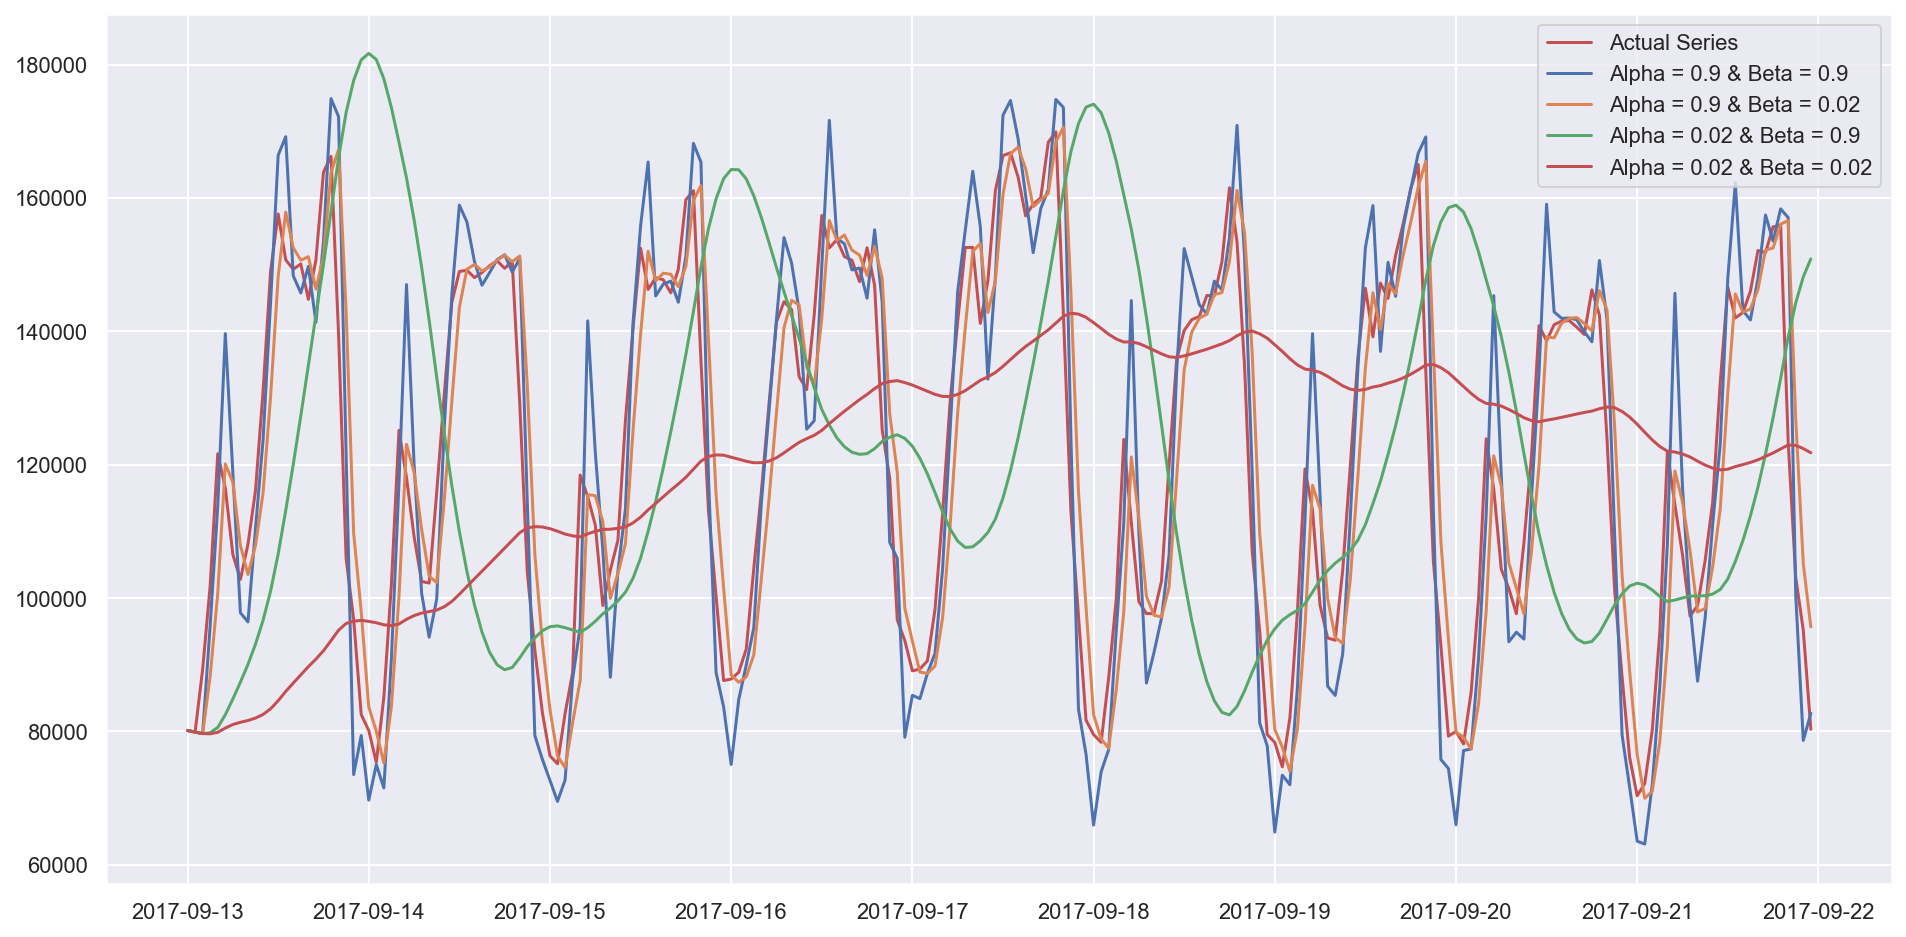

In [208]:
plot_double_exponential_smoothing(ads,[0.9,0.02],[0.9,0.02])

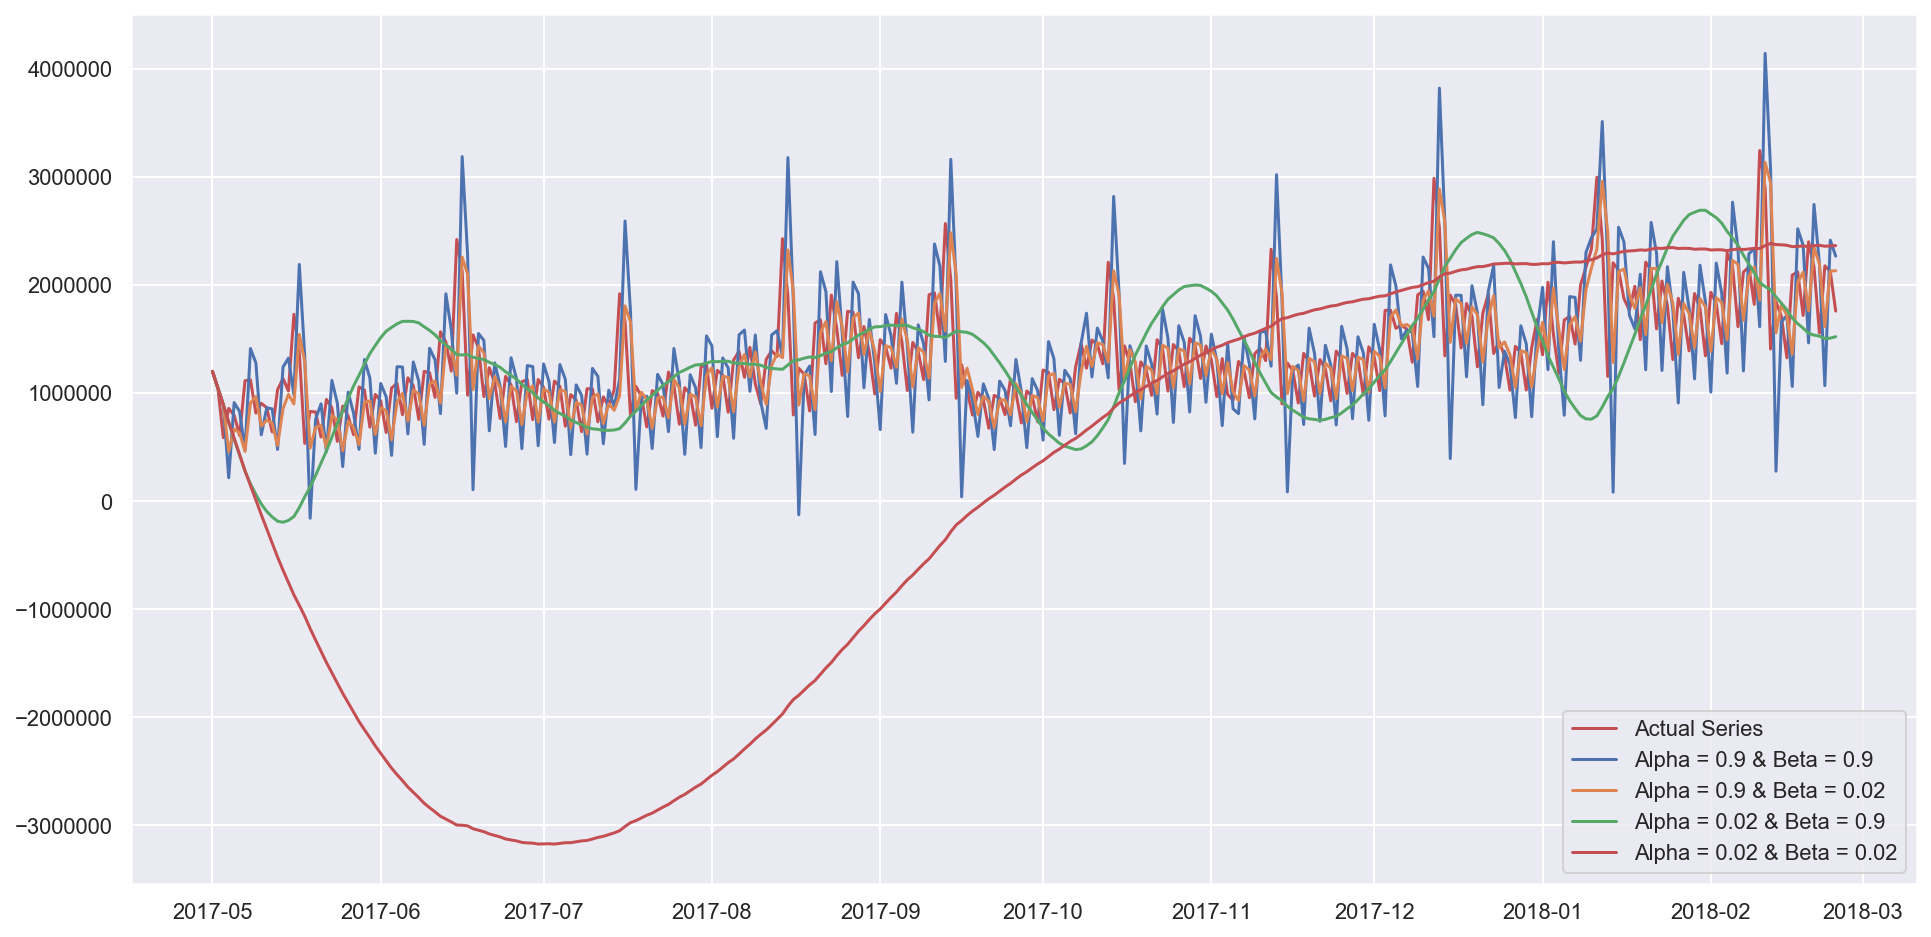

In [209]:
plot_double_exponential_smoothing(currency,[0.9,0.02],[0.9,0.02])

From above, we can see clearly that certain combinations of $\alpha$ and $\beta$ tend to produce some quite different results

## Holt-Winter's Algorithm for Prediction

$l_x=\alpha (y_x - s_{x-L})+(1-\alpha)(l_{x -1}+b_{x - 1})$
 
$b_x=\beta(l_x - l_{x−1})+(1-\beta)b_{x - 1}$

$s_x=\gamma(y_x - l_x)+(1-\gamma)s_{x-L}$

$\hat y_{x+m}=l_{x}+mb_x+s_{x-L+1+(m-1)modL}$

## Brutlag Algorithm for Anomaly Detection

$\hat y_{max_x}=l_{x-1}+b_{x-1}+s_{x-T}+m.d_{t-T}$
 
$\hat y_{min_x}=l_{x-1}+b_{x-1}+s_{x-T}-m⋅d_{t-T}$

$d_t=\gamma ∣y_t-\hat y_t∣+(1-\gamma)d_{t−T}$

Where $T$  is the length of the season, $d$ is the predicted deviation

In [278]:
class HoltWinters_TS_Predictor:
    
    def __init__(self, series, seaslen, alpha, beta, gamma, n_preds, scaling_factor = 1.96):
        self.series = series
        self.seaslen = seaslen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.scaling_factor = scaling_factor
        self.n_preds = n_preds




    def initial_trend(self):
        '''
        Initializing the trend to be as the average of the trend averages across all the seasons
        '''
        sum = 0.0
        for i in range(self.seaslen):
            sum += float( (self.series[i+self.seaslen] - self.series[i])/self.seaslen )
        return sum/self.seaslen


    def initial_season_components(self):
        '''
        The situation is even more complicated when it comes to initial values for the seasonal components.
        Briefly, we need to compute the average level for every observed season we have, 
        divide every observed value by the average for the season it’s in and finally average each of these numbers across our observed seasons. 
        '''
        #1. Compute the average level of every observed season we have
        season_averages = []
        seasonal = {}
        num_seasons = int(len(self.series)/self.seaslen)
        for num in range(num_seasons):
            season_averages.append(float(sum(self.series[num*self.seaslen : num*self.seaslen + self.seaslen]))/float(self.seaslen))

        #2. Divide every observed value by the average for the season it's in

        for i in range(self.seaslen):
            avg = 0.0
            for j in range(num_seasons):
                avg += self.series[i + j*self.seaslen] - season_averages[j]
            seasonal[i] = avg/num_seasons
        return seasonal

    ######
    ##
    ###change smooth to level
    ##
    ##


    def Triple_Exponential_Smoothing(self):

        '''
        The arguments to the function are the series of observed values, the season length, alpha, beta, gamma and the number of points we want forecasted.
        '''
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []    

        seasonals = self.initial_season_components()

        for i in range(len(self.series) + self.n_preds):


            if i == 0:      #i.e. Initialize all the components
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.seaslen])
                self.PredictedDeviation.append(0)
                self.UpperBound.append(self.result[0] + self.scaling_factor*self.PredictedDeviation[0])
                self.LowerBound.append(self.result[0] - self.scaling_factor*self.PredictedDeviation[0])


                continue #to the next iteration

            if i >= len(self.series): #Prediction Mode Activated

                m = i - len(self.series) +1
                self.result.append(smooth + m*trend + seasonals[i%self.seaslen])

                #While Predicting, It's generally better to increase the uncertainity in each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.009)

            else :     #The Real 'Meat' of the job
                current = self.series[i]                                                         #This smooth is still the previous smooth in this context
                last_smooth, smooth = smooth, self.alpha*(current - seasonals[i%self.seaslen]) + (1-self.alpha)*(smooth + trend)
                trend = self.beta*(smooth - last_smooth) + (1-self.beta)*trend
                seasonals[i%self.seaslen] = self.gamma*(current - smooth) + (1-self.gamma)*seasonals[i%self.seaslen]
                self.result.append(smooth + trend + seasonals[i%self.seaslen])

                #Brutlag Anomaly Detection Part
                                                                                                                                               #d_{t-T}
                self.PredictedDeviation.append(self.gamma*(np.abs(self.series[i] - self.result[i])) + (1-self.gamma)*self.PredictedDeviation[-1])






            self.UpperBound.append(self.result[-1] + self.scaling_factor*self.PredictedDeviation[-1])
            self.LowerBound.append(self.result[-1] - self.scaling_factor*self.PredictedDeviation[-1])    

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.seaslen])

                
                    
                

$l_x=\alpha (y_x - s_{x-L})+(1-\alpha)(l_{x -1}+b_{x - 1})$
 
$b_x=\beta(l_x - l_{x−1})+(1-\beta)b_{x - 1}$

$s_x=\gamma(y_x - l_x)+(1-\gamma)s_{x-L}$

$\hat y_{x+m}=l_{x}+mb_x+s_{x-L+1+(m-1)modL}$

$\hat y_{max_x}=l_{x-1}+b_{x-1}+s_{x-T}+m.d_{t-T}$
 
$\hat y_{min_x}=l_{x-1}+b_{x-1}+s_{x-T}-m⋅d_{t-T}$

$d_t=\gamma ∣y_t-\hat y_t∣+(1-\gamma)d_{t−T}$

## Time Series Cross Validation

#### The idea is rather simple -- we train our model on a small segment of the time series from the beginning until some $t$, make predictions for the next $t+n$ steps, and calculate an error. Then, we expand our training sample to $t+n$ value, make predictions from $t+n$ until $t+2n$, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as $n$ will fit between the initial training sample and the last observation.

Scikit Learn fortunately have implementation of such algorithm and we'll reside to use that as well

#### _NOTE_ `**seaslen = 24** because we have daily seasonality in ads and time stamp is hourly.`

In [304]:
from sklearn.model_selection import TimeSeriesSplit

def Time_Series_CValidation_Score(param_abg, series, loss_function = mean_squared_error, season_len = 24):
    
    errors = []
    
    values = series.values
    alpha, beta, gamma = param_abg
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters_TS_Predictor(series=values[train], seaslen=season_len, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.Triple_Exponential_Smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

#### The next thing we do is to minimize our loss function, but, we have to be careful as this problem of minimizing the loss function carries a constraint with it that all the parameters defining Holts-Winter as well as other Exponential Smoothing Algos, should have $\alpha$, $\beta$ \& $\gamma$ $\in [0,1]$

#### For such a constraint, Truncated Newton Conjugate Gradient Algorithm (TNC) works just fine 

#### FUTURE note: `Try SLSQP`

In [305]:
train_data = ads.Ads[:-20] #30 points left out for TESTING


optimizer = minimize(Time_Series_CValidation_Score,x0=[0,0,0],args=(train_data,mean_squared_log_error),method='TNC',bounds=((0,1),(0,1),(0,1)))
alpha, beta, gamma = optimizer.x
print(alpha, beta, gamma)


model = HoltWinters_TS_Predictor(series=train_data,alpha=alpha,beta=beta,gamma=gamma,seaslen=24,n_preds=50, scaling_factor=3)
model.Triple_Exponential_Smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237


## TODO: Plot the Graphs

In [306]:
def plotHoltWinters(model, series, plot_bounds = True, plot_anomalies = True):
    
    plt.figure(figsize = (20,10))
    plt.plot(model.result,label = 'Model Values')
    plt.plot(series.values,label = 'Actual Values')
    
    error = mean_absolute_percentage_error(series.values,model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {}%".format(error))
    
    if plot_bounds:
        plt.plot(model.UpperBound,'r--',alpha=0.5)
        plt.plot(model.LowerBound, 'r--', label = 'Upper/Lower Confidence Bounds',alpha = 0.5)
       # plt.fill_between(x=range(0,len(model.result)),y1=model.LowerBound,y2=model.UpperBound,alpha=0.2,color = 'grey')
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(series))
            mask = (series.values.reshape(-1,) > model.UpperBound[:len(series)]) | (series.values.reshape(-1,) < model.LowerBound[:len(series)])
            anomalies[mask] = series.values[mask].reshape(-1,)
            plt.plot(anomalies,'o',label = "Anomalies")
            #Lowmask = series.values.reshape(-1,) < model.LowerBound[:len(series)]
            #plt.plot(series.values[Lowmask],'o',label = "Anomalies")
    plt.vlines(len(series),min(model.LowerBound),max(model.UpperBound), linestyle = 'dashed')     
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.legend()

In [307]:
mean_absolute_percentage_error(ads.values,model.result[:len(series)])

27.3067387860659

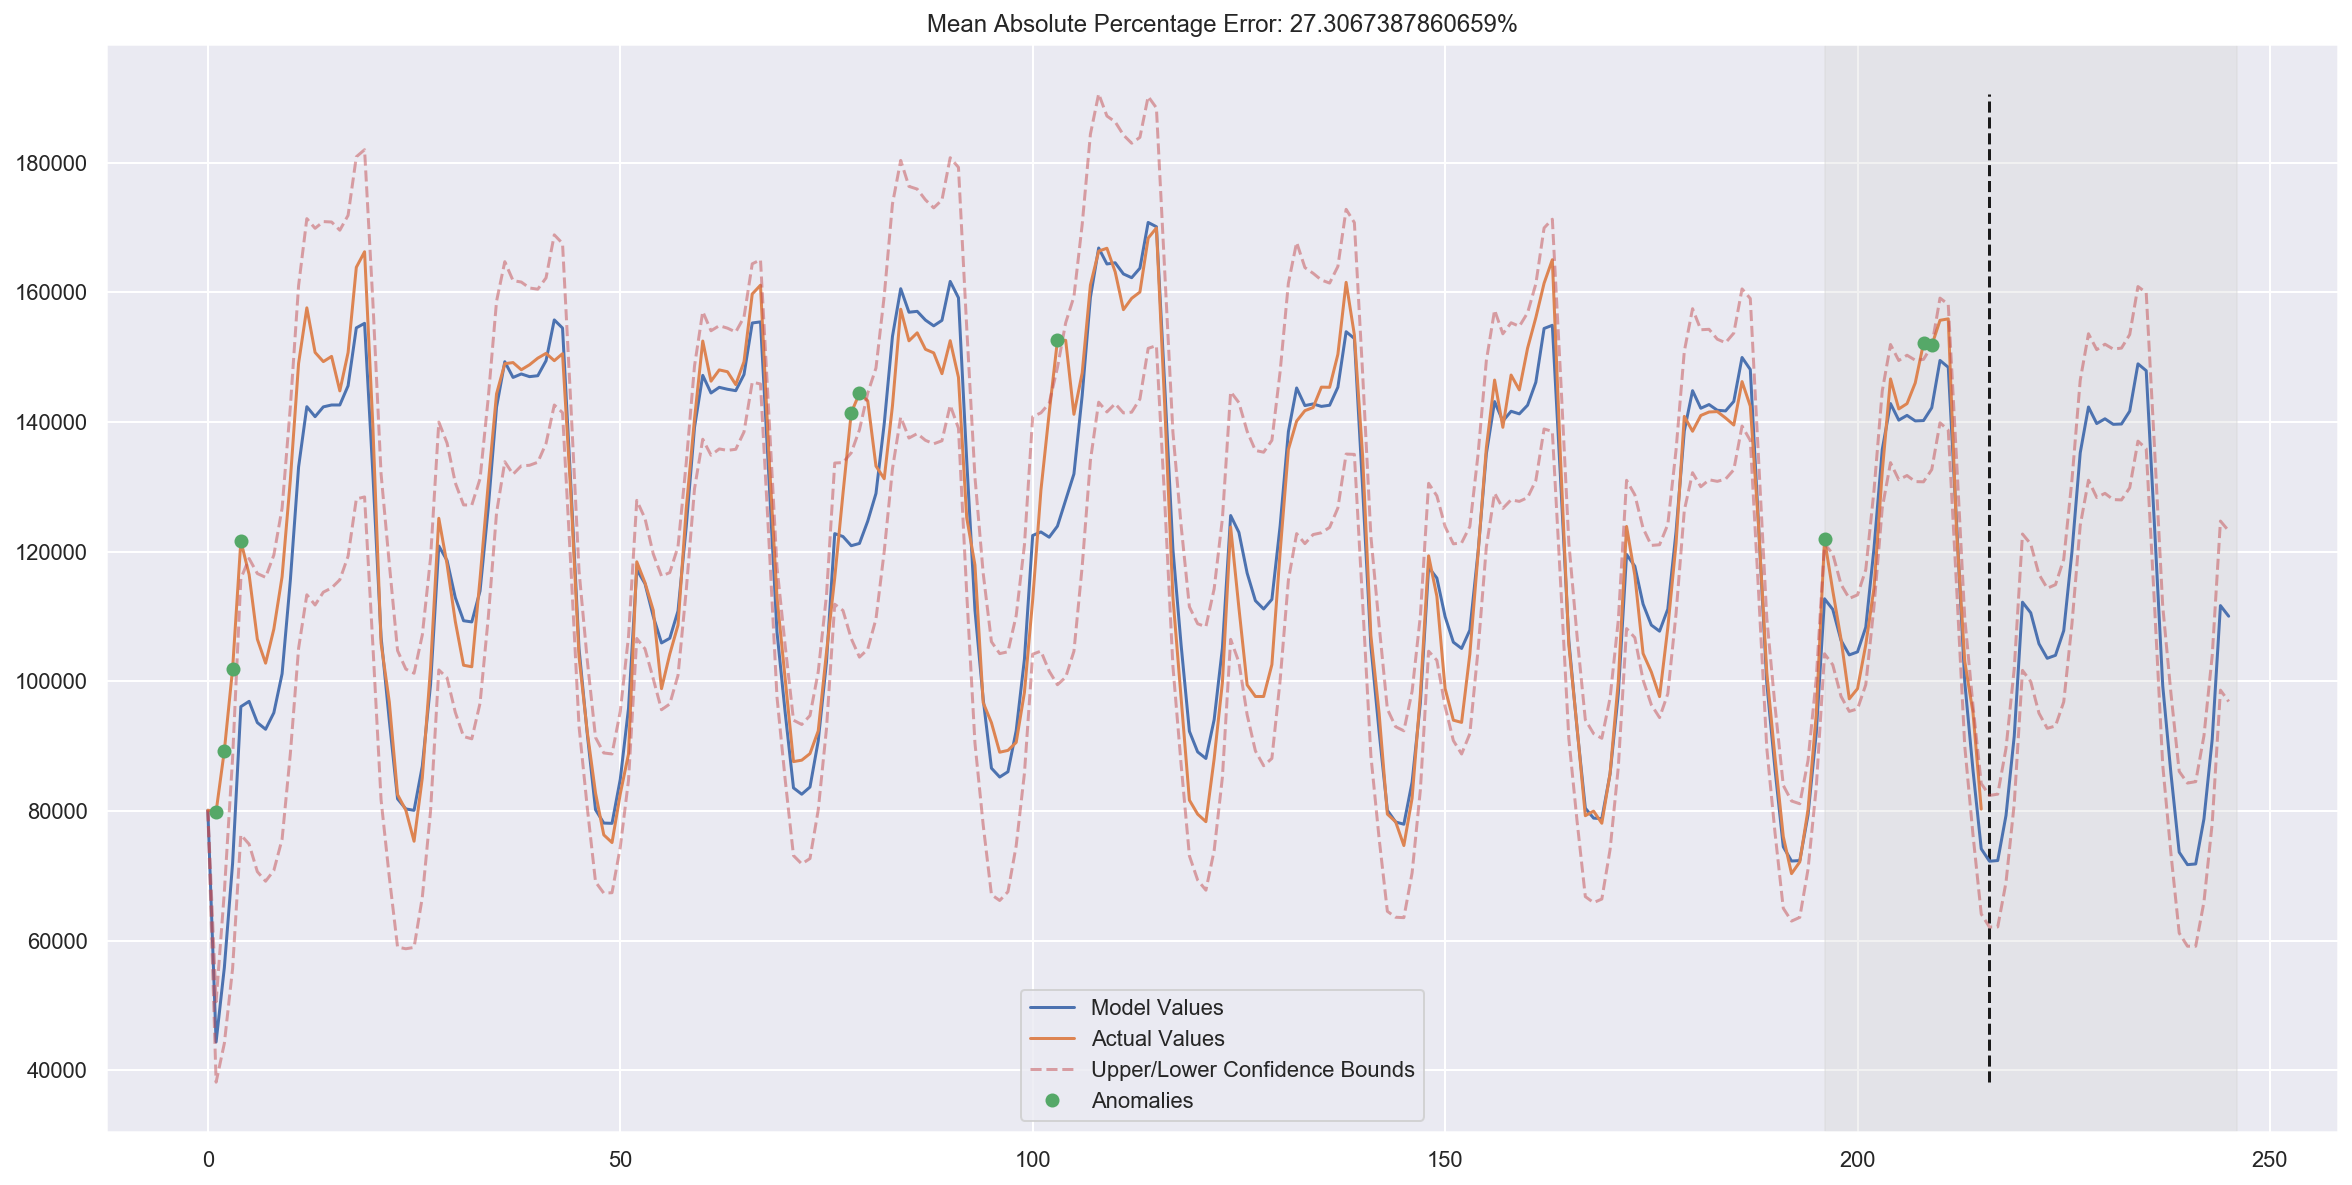

In [308]:
plotHoltWinters(model,ads,plot_anomalies=True,plot_bounds=True)

Text(0.5, 1.0, "Deviation Predicted from Brutlag's Method")

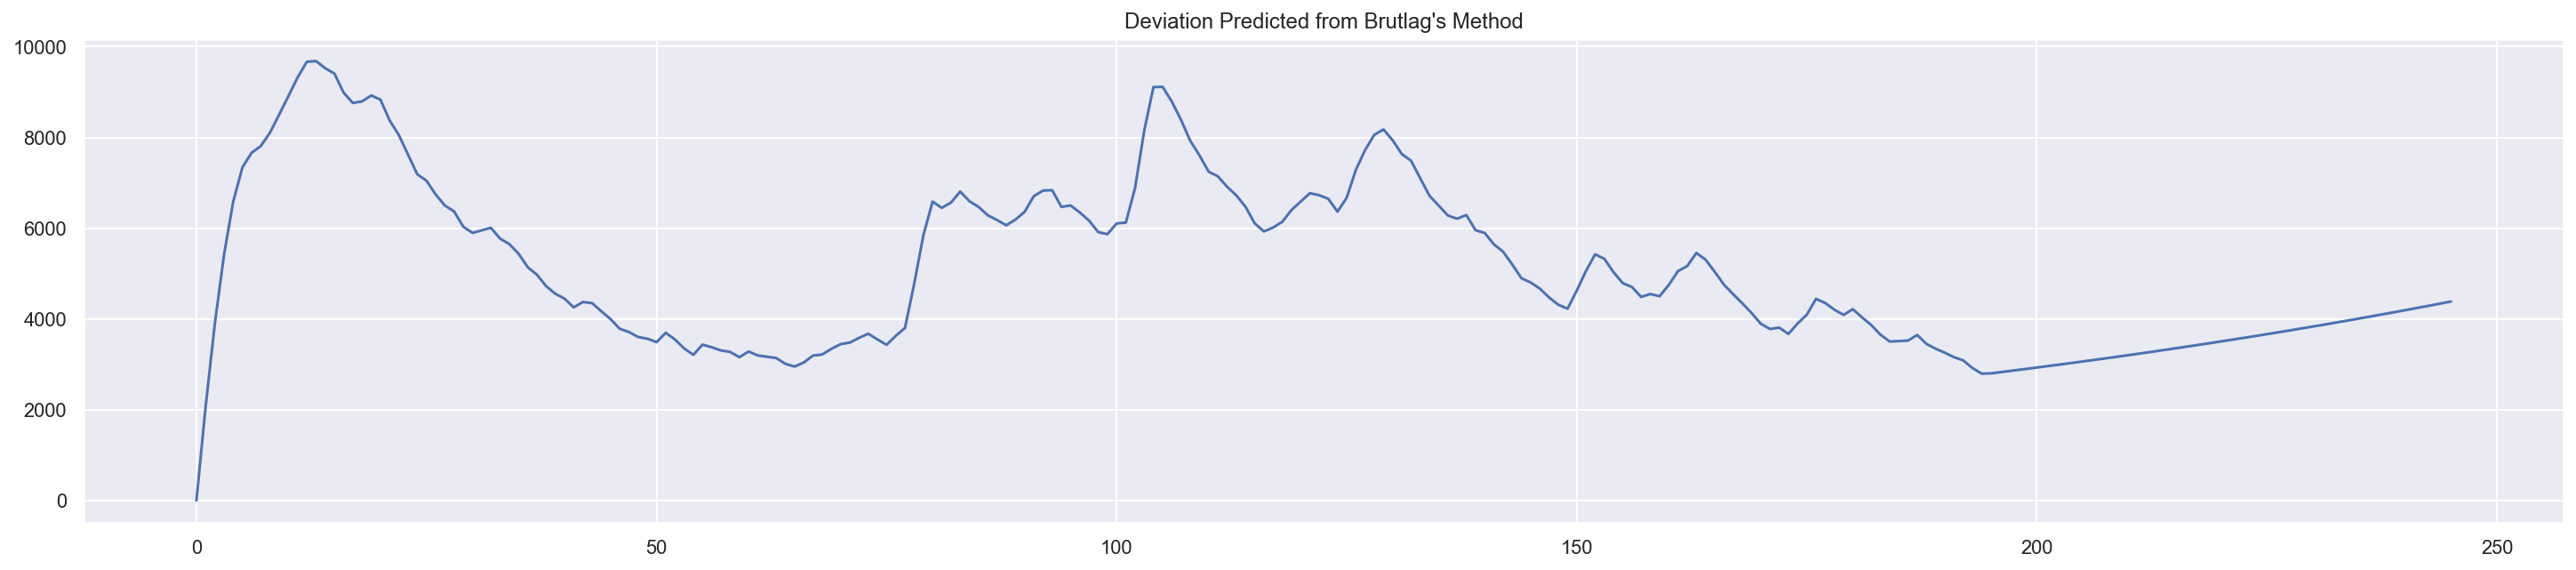

In [309]:
plt.figure(figsize = (25,5))
plt.plot(model.PredictedDeviation)
plt.title("Deviation Predicted from Brutlag's Method")

Implementing the model for currency series

In [311]:
train_data = currency.GEMS_GEMS_SPENT[:-50]
seas_len = 30 #Monthly Seasonality
optimizer = minimize(Time_Series_CValidation_Score,x0=[0,0,0],args=(train_data,mean_absolute_error,seas_len),method='TNC',bounds=((0,1),(0,1),(0,1)))
alpha, beta, gamma = optimizer.x
print(alpha, beta, gamma)


model2 = HoltWinters_TS_Predictor(series=train_data,alpha=alpha,beta=beta,gamma=0.00943678056045777,seaslen=seas_len,n_preds=100, scaling_factor=3)
model2.Triple_Exponential_Smoothing()

0.011967654151850304 0.05711265666815135 0.0


In [301]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.011967654151850304 0.05711265666815135 0.0
Wall time: 3.78 s


0.012841445048055122 0.04883371471892228 0.00943678056045777

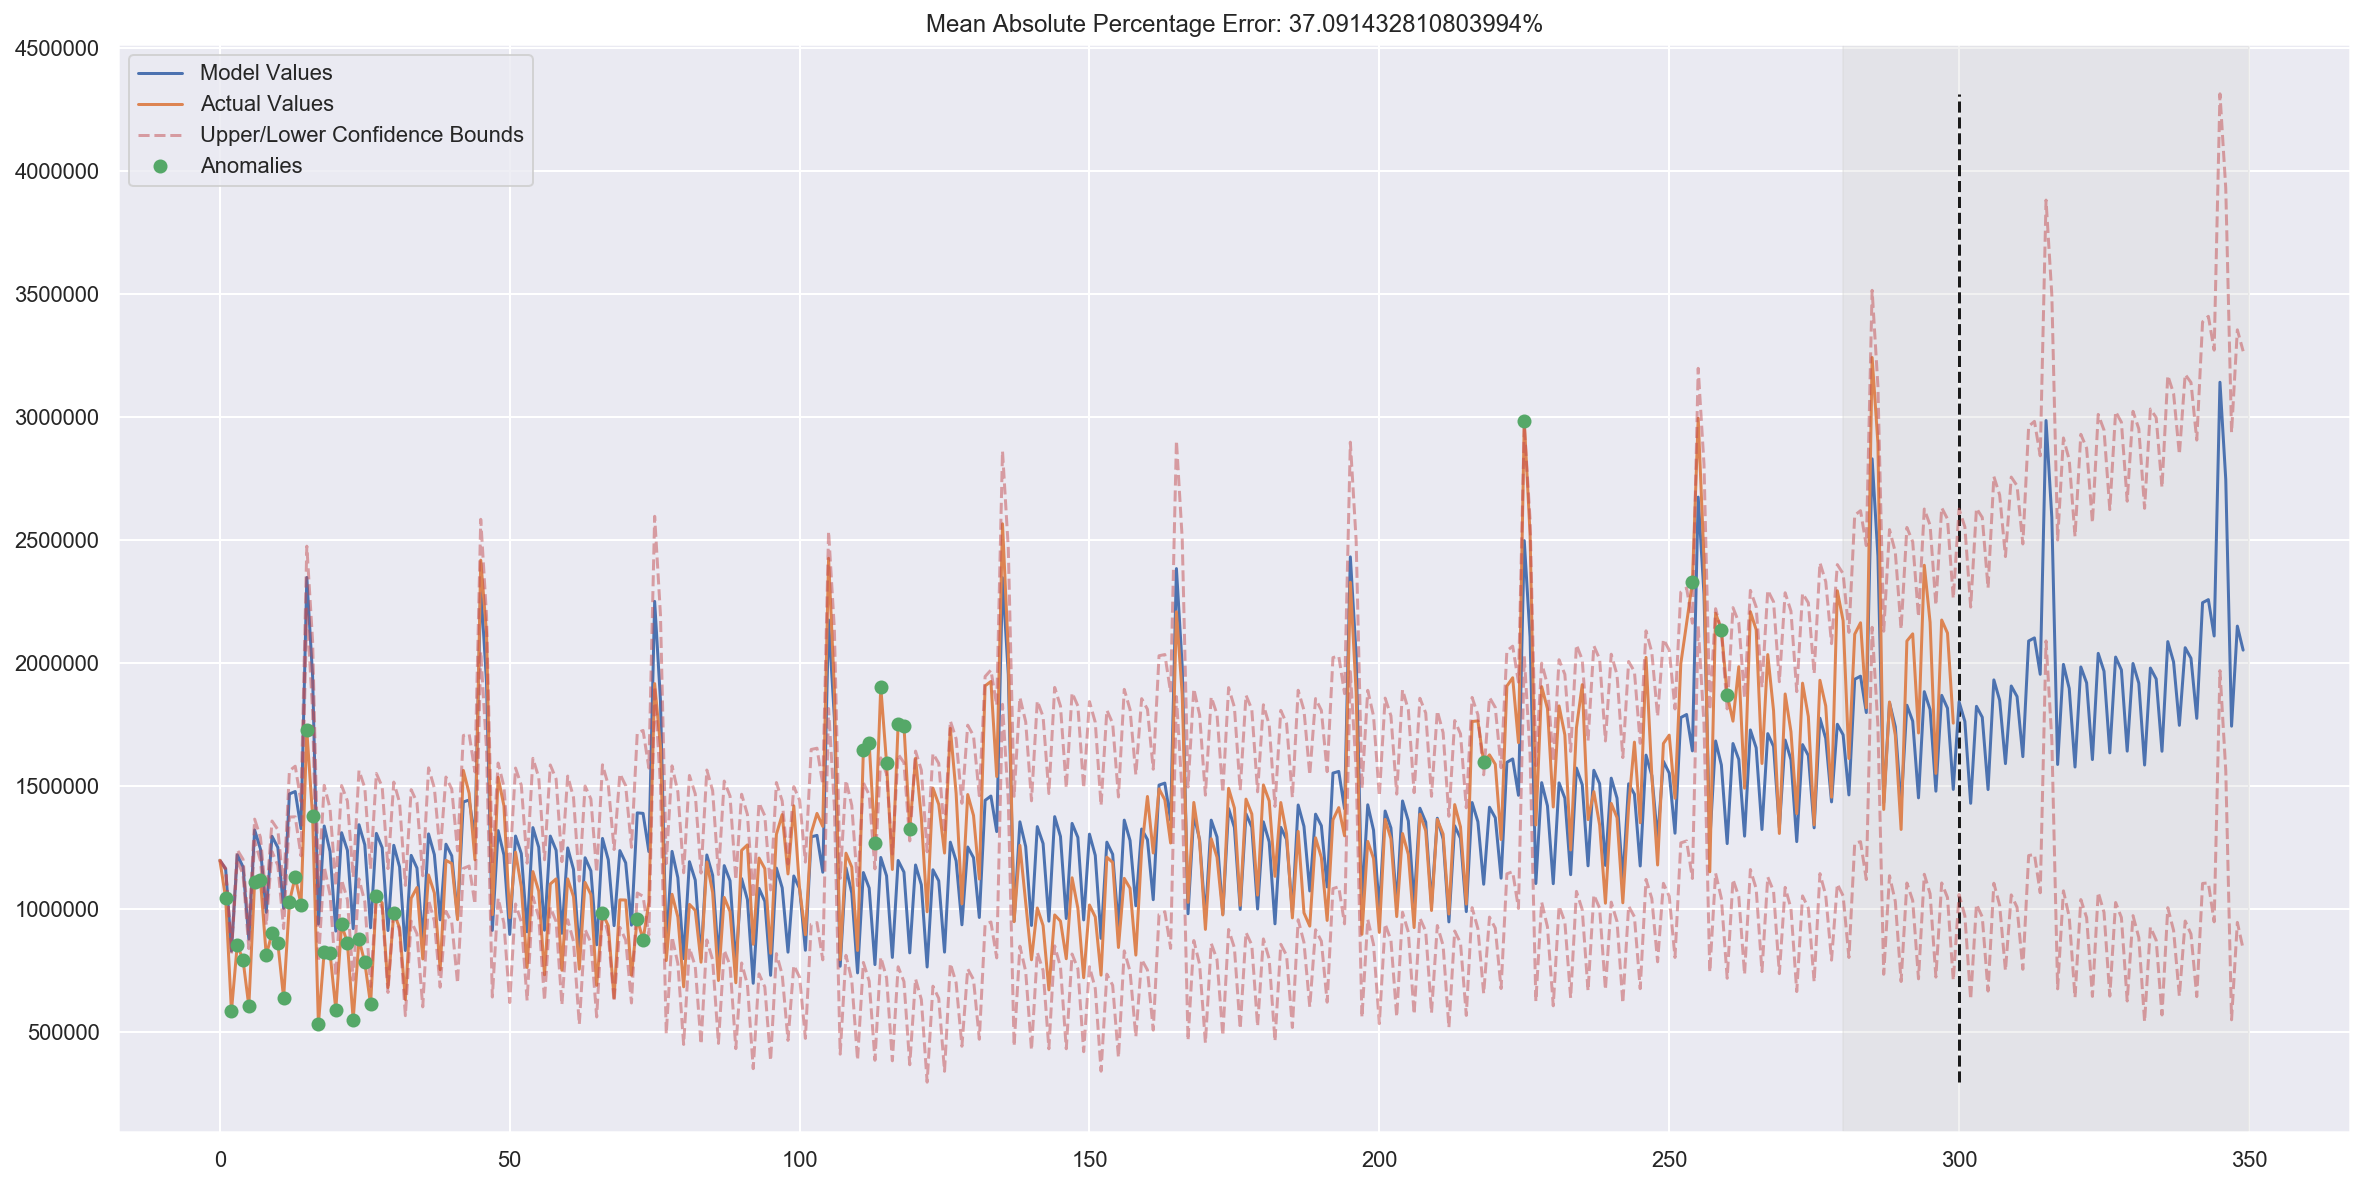

In [312]:
plotHoltWinters(model2,currency)

Text(0.5, 1.0, 'Predicted Deviation using Brutlag Method')

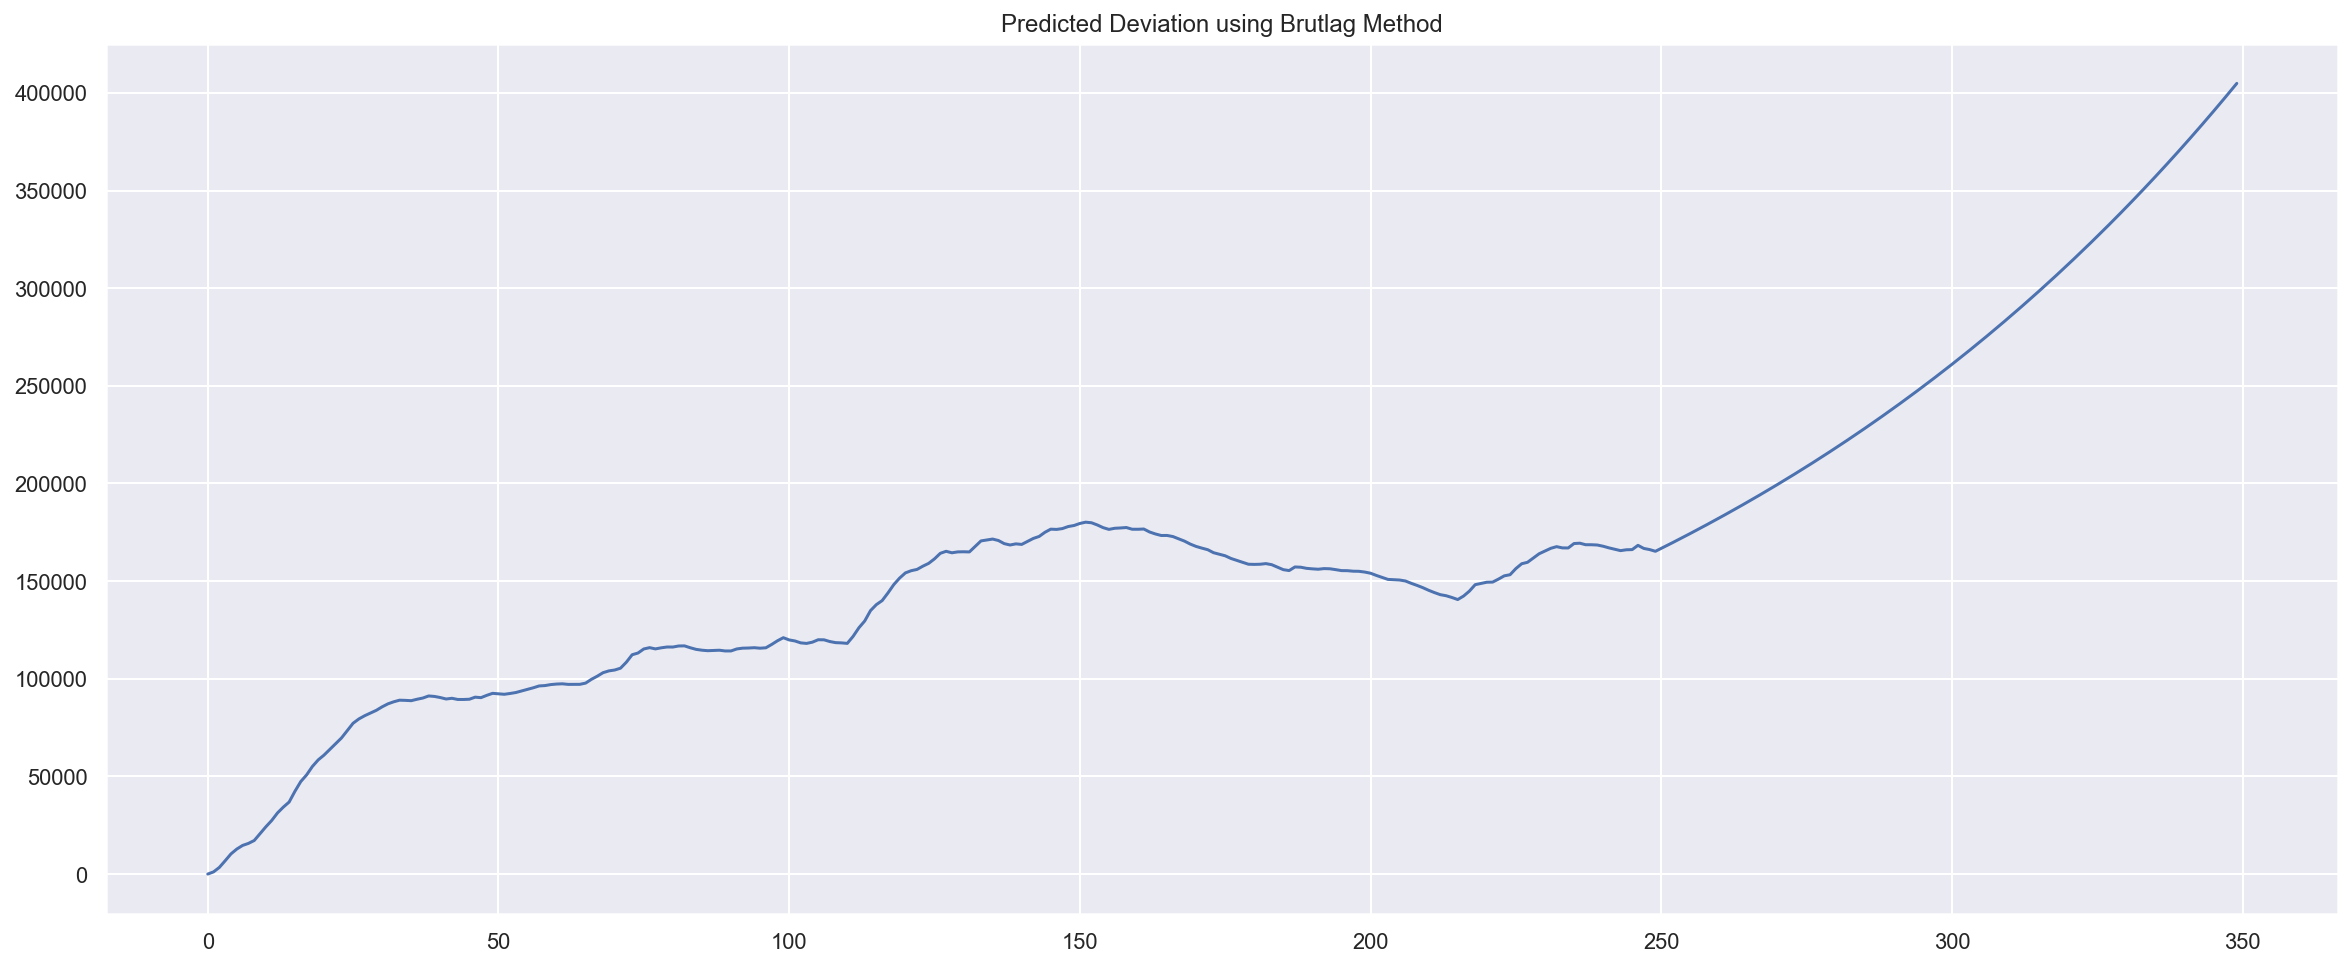

In [318]:
plt.figure(figsize = (20,8))
plt.plot(model2.PredictedDeviation)
plt.title("Predicted Deviation using Brutlag Method")